# Experiment #1: Query Engineering
Started: 2025-01-16

In [1]:
# Only run once, unless restarting kernel
import os
os.chdir('../')
print(os.getcwd())  # Should output the project folder

/home/vlad/Desktop/lmu_bachelor_thesis/code/VariationalInformationPursuit


In [2]:
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from mutagenicity_dataset import *
from feature_engineering.node_features import *

/home/vlad/anaconda3/envs/vip_graphs/lib/python3.12/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1729805341246/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()


In [3]:
### LOAD DATASET ###
data_path = './data'
dataset = TUDataset(root=data_path, name='Mutagenicity', transform=get_combined_mapping_transform())

In [4]:
# data = dataset[2]
# g = to_networkx(data, node_attrs=['x'], to_undirected=True)
# nx.draw(g)

# print(data.y.item())
# print(data.x)
# print(data.graph_class_label)
# print(data.node_feature_labels)
# print(data.edge_feature_labels)

## Feature Creation

In [5]:
# Create list of empty feature dictionaries for each data sample
feature_list = []  
for i in range(len(dataset)):
    feature_list.append({})

### Atom Type Count

In [6]:
atom_types = list(get_node_feature_label_mapping().values())

# Create features
count_dict = {}
for atom in atom_types:
    for i, data in enumerate(dataset):
        feature_list[i][f'{atom}_count'] = count_atom_type(data, atom)      

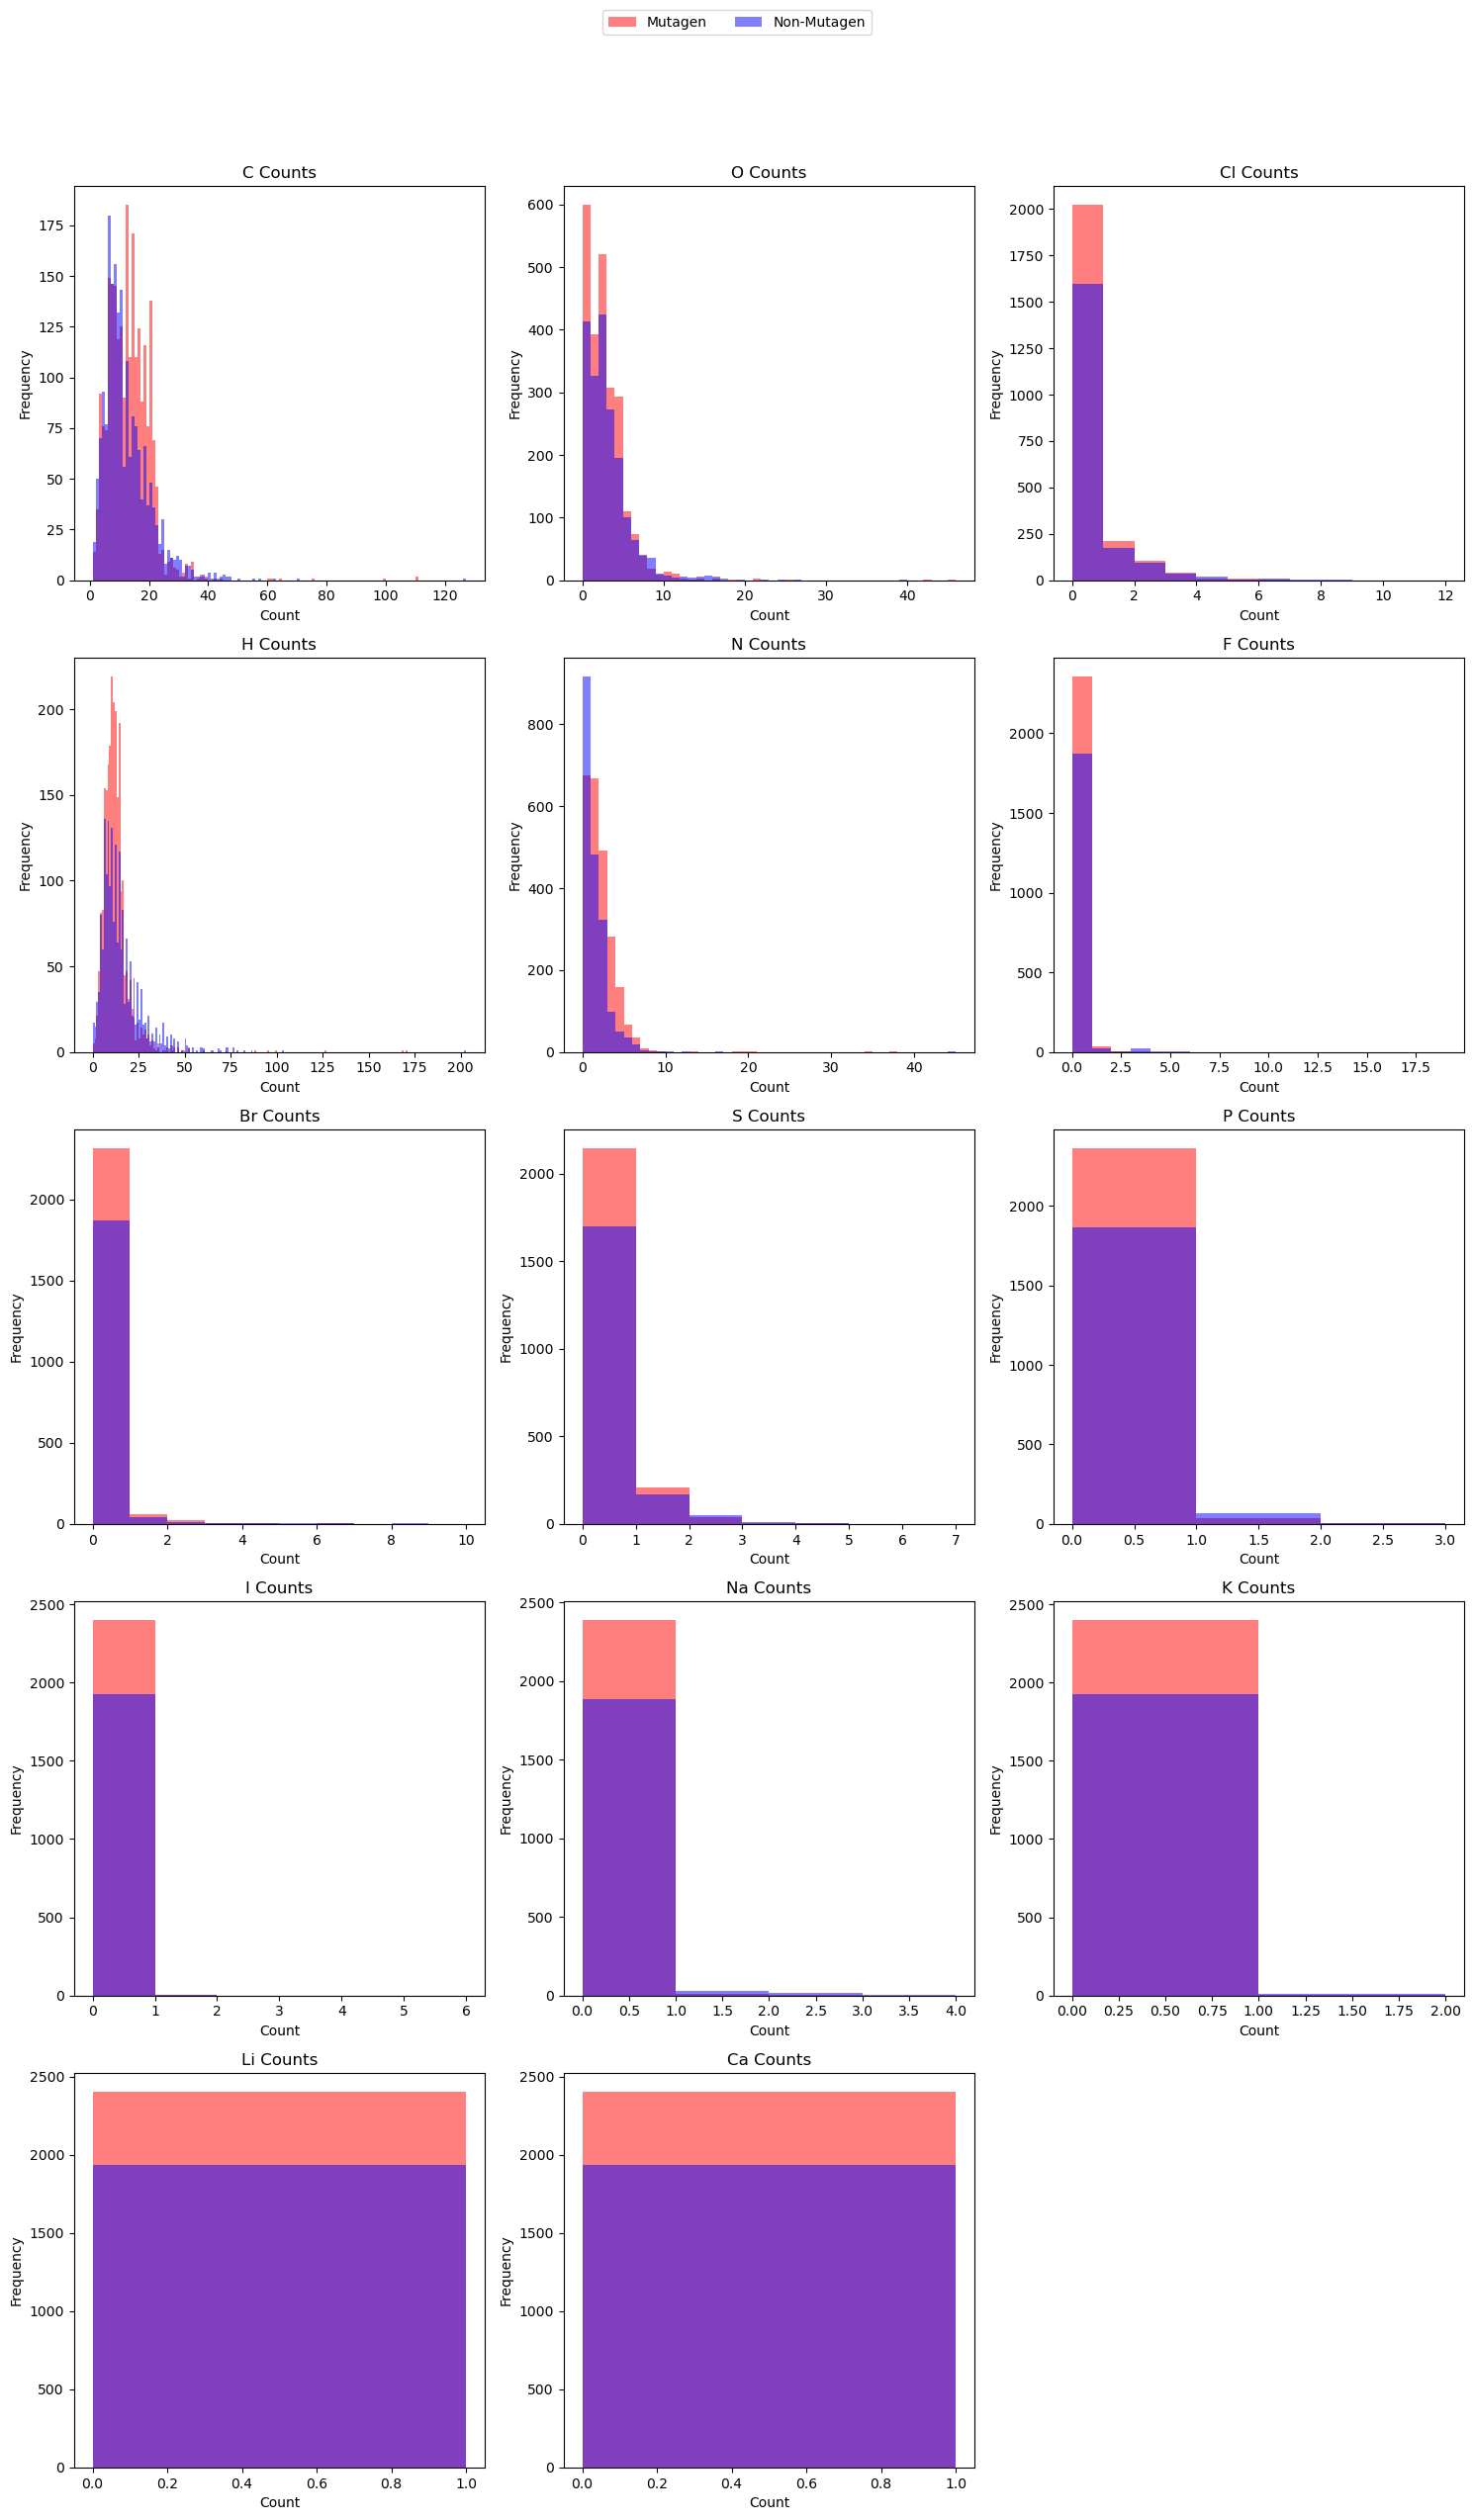

In [8]:
# Visualize features
ncols = 3
nrows = (len(atom_types) // ncols) + ((len(atom_types) % ncols) > 0)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axs = axs.flatten()

legend_handles = None
legend_labels = None
for idx, atom in enumerate(atom_types):
    mutagen_values = [features[f'{atom}_count'] for i, features in enumerate(feature_list) if dataset[i].mutagenicity == 'mutagen']
    nonmutagen_values = [features[f'{atom}_count'] for i, features in enumerate(feature_list) if dataset[i].mutagenicity == 'nonmutagen']
    
    joined = mutagen_values + nonmutagen_values
    min_count = min(joined)
    max_count = max(joined)

    ax = axs[idx]
    ax.hist(mutagen_values, bins=range(min_count, max_count + 1), align='mid', alpha=0.5, label='Mutagen', color='red')
    ax.hist(nonmutagen_values, bins=range(min_count, max_count + 1), align='mid', alpha=0.5, label='Non-Mutagen', color='blue')

    if legend_handles is None and legend_labels is None:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
    
    ax.set_title(f'{atom} Counts')
    ax.set_xlabel(f'Count')
    ax.set_ylabel('Frequency')

# Remove empty subplots if the number of atom types is less than the number of subplot slots
for idx in range(len(atom_types), len(axs)):
    fig.delaxes(axs[idx])

# Add a single legend to the figure
fig.legend(legend_handles, legend_labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02))

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for the legend
plt.show()

In [8]:
# fig, axs = plt.subplots(nrows=2, ncols=14, figsize=(50, 6))
# for i, atom in enumerate(node_feature_labels):
#     # mutagen_count_list = count_dict[atom]['mutagen']
#     # nonmutagen_count_list = count_dict[atom]['nonmutagen']
#     # joined = mutagen_count_list + nonmutagen_count_list
#     # min_count = min(joined)
#     # max_count = max(joined)

#     ax = axs[0, i]
#     count_list = count_dict[atom]['mutagen']
#     ax.hist(count_list, bins=range(min(count_list), max(count_list) + 1), align='mid', edgecolor='black')
#     ax.set_title(f'{atom} (mutagen)')
    
#     ax = axs[1, i]
#     count_list = count_dict[atom]['nonmutagen']
#     ax.hist(count_list, bins=range(min(count_list), max(count_list) + 1), align='mid', edgecolor='black')
#     ax.set_title(f'{atom} (nonmutagen)')

### Motif Count

In [5]:
import itertools

16
32


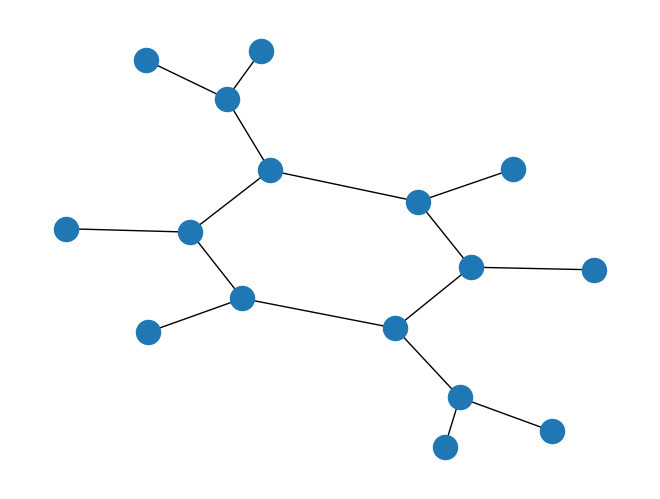

In [6]:
data = dataset[0]
G = to_networkx(data, to_undirected=True, edge_attrs=['edge_attr'], node_attrs=['x'])
nx.draw(G)
print(data.num_nodes)
print(data.num_edges)

In [7]:
# Get all motifs in graph

# Naive greedy algorithm
def extract_all_motifs_in_graph(G, min_num_nodes_in_motif, max_num_nodes_in_motif):
    nodes = list(G.nodes())
    all_motifs = []
    for k in range(min_num_nodes_in_motif, max_num_nodes_in_motif + 1):
        print(k)
        for subset in itertools.combinations(nodes, k):
            SG = G.subgraph(subset)  # Induced subgraph
            if nx.is_connected(SG):  # Must be connected (No isolated nodes)
                all_motifs.append(SG)
    return all_motifs

n = G.number_of_nodes()
all_motifs = extract_all_motifs_in_graph(G, min_num_nodes_in_motif=2, max_num_nodes_in_motif=n-1)

2
3
4
5
6
7
8
9
10
11
12
13
14
15


This is taking way to long. Let's try to estimate how long it would take to count motifs in all samples in the dataset.

In [8]:
# Get list of number of nodes in each sample in the dataset
num_nodes = []
for data in dataset:
    num_nodes.append(data.num_nodes)

# Get average number of nodes in a graph in the dataset
avg_num_nodes = np.average(num_nodes)
print(avg_num_nodes)

30.317731150564907


In [9]:
# Get list of number of edges in each sample in the dataset
num_edges = []
for data in dataset:
    num_edges.append(data.num_edges / 2)  # divide by two because each undirected edge is 2 directed edges in opposite directions

# Get average number of edges in a graph in the dataset
avg_num_edges = np.average(num_edges)
print(avg_num_edges)

30.76942587041734


In [10]:
# # Using the first sample in the dataset, time how long computation takes for one iteration
# data = dataset[0]
# G = to_networkx(data, to_undirected=True, edge_attrs=['edge_attr'], node_attrs=['x'])

# n = G.number_of_nodes()
# all_motifs = extract_all_motifs_in_graph(G, min_num_nodes_in_motif=2, max_num_nodes_in_motif=n-1)

The search space for querying for all possible motifs.

In [11]:
import math

# Best case scenario:
n = 14  # num of possible node features
e = 3  # num of possible edge features
V = 10  # num of nodes in graph (currently is the avg number of nodes in a graph in the dataset)
E = 9  # num of edges in graph (currently is the avg number of edges in a graph in the dataset)
min_nodes_in_motif = 2

val = 0
for k in range(min_nodes_in_motif, V):
    val += math.comb(V, k) * math.comb(n+k-1, k) * math.comb(e+(k-1)-1, k-1)

print(f'{val:,d}')

971,414,535


#### Counting certain functional groups (motifs with restrictions from chemistry)

In [12]:
from feature_engineering.motif_features import *
from tqdm import tqdm

Define motif to count in graphs

[(0, {'atoms': 'H'}), (2, {'atoms': 'N'}), (1, {'atoms': 'H'})]
[(0, 2, {'bonds': '1'}), (2, 1, {'bonds': '1'})]


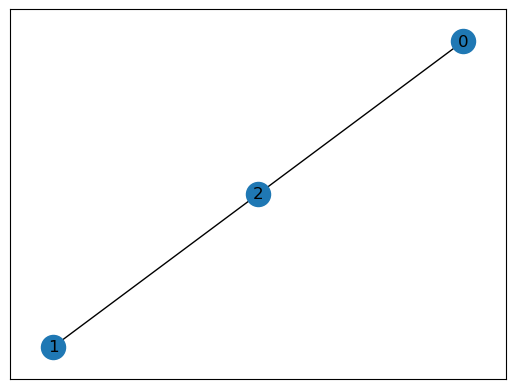

In [13]:
# NH2
edgelist = [(0, 2), (1, 2)]
NH2 = nx.Graph(edgelist)

NH2.nodes[0]['atoms'] = 'H'
NH2.nodes[1]['atoms'] = 'H'
NH2.nodes[2]['atoms'] = 'N'

NH2.edges[0, 2]['bonds'] = '1'
NH2.edges[1, 2]['bonds'] = '1'

print(NH2.nodes.data())
print(NH2.edges.data())
nx.draw_networkx(NH2, with_labels=True)

[(0, {'atoms': 'C'}), (1, {'atoms': 'C'}), (2, {'atoms': 'C'}), (3, {'atoms': 'C'}), (4, {'atoms': 'C'}), (5, {'atoms': 'C'})]
[(0, 1, {'bonds': '1'}), (0, 5, {'bonds': '1'}), (1, 2, {'bonds': '1'}), (2, 3, {'bonds': '1'}), (3, 4, {'bonds': '1'}), (4, 5, {'bonds': '1'})]


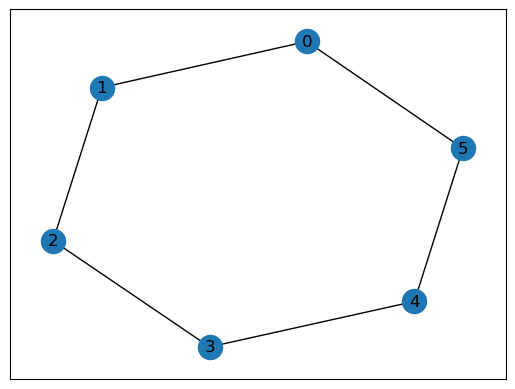

In [14]:
# C6 ring
edgelist = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0)]
C6 = nx.Graph(edgelist)

for i in range(6):
    C6.nodes[i]['atoms'] = 'C'
    C6.edges[i, (i+1) % 6]['bonds'] = '1'

print(C6.nodes.data())
print(C6.edges.data())
nx.draw_networkx(C6, with_labels=True)

Count motif in each sample in the dataset using "unique" counting algorithm.

In [15]:
list(get_node_feature_label_mapping().values())

['C', 'O', 'Cl', 'H', 'N', 'F', 'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']

In [16]:
nh2_counts = []
for data in tqdm(dataset):
    G = to_networkx(data, to_undirected=True, edge_attrs=['bonds'], node_attrs=['atoms'])
    count, _ = count_node_induced_subgraph_isomorphisms(G, NH2, use_v2=False)
    nh2_counts.append(count)

100%|██████████| 4337/4337 [00:03<00:00, 1242.57it/s]


In [17]:
c6_counts = []
for data in tqdm(dataset):
    G = to_networkx(data, to_undirected=True, edge_attrs=['bonds'], node_attrs=['atoms'])
    count, _ = count_node_induced_subgraph_isomorphisms(G, C6, use_v2=False)
    c6_counts.append(count)

100%|██████████| 4337/4337 [00:09<00:00, 478.17it/s]


Count motif in each sample in the dataset using just networkx GraphMatcher, which will have some structural duplicates (just to compare runtime).

In [18]:
nh2_counts_alt = []
for data in tqdm(dataset):
    G = to_networkx(data, to_undirected=True, edge_attrs=['bonds'], node_attrs=['atoms'])
    isomatcher = nx.isomorphism.GraphMatcher(G, NH2, node_match=node_match, edge_match=edge_match)
    count = len(list(isomatcher.subgraph_isomorphisms_iter()))
    nh2_counts_alt.append(count)

100%|██████████| 4337/4337 [00:03<00:00, 1187.24it/s]


In [19]:
c6_counts_alt = []
for data in tqdm(dataset):
    G = to_networkx(data, to_undirected=True, edge_attrs=['bonds'], node_attrs=['atoms'])
    isomatcher = nx.isomorphism.GraphMatcher(G, C6, node_match=node_match, edge_match=edge_match)
    count = len(list(isomatcher.subgraph_isomorphisms_iter()))
    c6_counts_alt.append(count)

100%|██████████| 4337/4337 [00:09<00:00, 480.68it/s]


It seems to take about half the time when just computing the pure subgraph isomorphisms, and not removing the duplicates.

Compute stats.

In [21]:
# Compare motif count to mutagenicity
mutagenicities = []
for data in dataset:
    mutagenicities.append(data.mutagenicity)
print(mutagenicities)

['mutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'mutagen', 'mutagen', 'mutagen', 'mutagen', 'mutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'mutagen', 'mutagen', 'mutagen', 'mutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'mutagen', 'mutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'mutagen', 'mutagen', 'nonmutagen', 'mutagen', 'mutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'mutagen', 'mutagen', 'mutagen', 'mutagen', 'nonmutagen', 'nonmutagen', 'mutagen', 'mutag

In [22]:
mutag_indices = [idx for idx, val in enumerate(mutagenicities) if val == 'mutagen']
nonmutag_indices = [idx for idx, val in enumerate(mutagenicities) if val == 'nonmutagen']

nh2_counts = np.array(nh2_counts)
c6_counts = np.array(c6_counts)

# NH2
mutag_nh2_counts = nh2_counts[mutag_indices]
nonmutag_nh2_counts = nh2_counts[nonmutag_indices]

# C6
mutag_c6_counts = c6_counts[mutag_indices]
nonmutag_c6_counts = c6_counts[nonmutag_indices]

In [23]:
nh2_counts = np.array(nh2_counts)
min_count = min(nh2_counts)
max_count = max(nh2_counts)

In [25]:
mutag_motif_counts = mutag_nh2_counts
nonmutag_motif_counts = nonmutag_nh2_counts

mutag_motif_counts = np.array(mutag_motif_counts)
mutag_hist = np.histogram(mutag_motif_counts, bins=range(min_count, max_count+2))
mutag_percents = [round(float(val / mutag_hist[0].sum()), 4) for val in mutag_hist[0]] 
print(f'Mutag hist: {mutag_hist}')
print(f'Mutag percents: {mutag_percents}')
print()

nonmutag_motif_counts = np.array(nonmutag_motif_counts)
nonmutag_hist = np.histogram(nonmutag_motif_counts, bins=range(min_count, max_count+2))
nonmutag_percents = [round(float(val / nonmutag_hist[0].sum()), 4) for val in nonmutag_hist[0]] 
print(f'Nonmutag hist: {nonmutag_hist}')
print(f'Nonmutag percents: {nonmutag_percents}')

Mutag hist: (array([1899,  359,  135,    4,    3,    1,    0]), array([0, 1, 2, 3, 4, 5, 6, 7]))
Mutag percents: [0.7909, 0.1495, 0.0562, 0.0017, 0.0012, 0.0004, 0.0]

Nonmutag hist: (array([1682,  209,   39,    4,    1,    0,    1]), array([0, 1, 2, 3, 4, 5, 6, 7]))
Nonmutag percents: [0.8688, 0.108, 0.0201, 0.0021, 0.0005, 0.0, 0.0005]


Text(0, 0.5, 'Number of molecules')

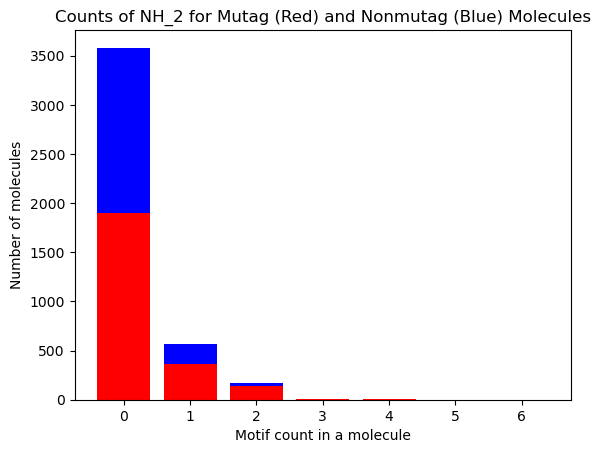

In [26]:
# NH2
fig, ax = plt.subplots()

x = range(min_count, max_count+1)
y_mutag = mutag_hist[0]
y_nonmutag = nonmutag_hist[0]

ax.bar(x, y_mutag, color='r')
ax.bar(x, y_nonmutag, bottom=y_mutag, color='b')
ax.set_title('Counts of NH_2 for Mutag (Red) and Nonmutag (Blue) Molecules')
ax.set_xlabel('Motif count in a molecule')
ax.set_ylabel('Number of molecules')

In [27]:
# C6
mutag_motif_counts = mutag_c6_counts
nonmutag_motif_counts = nonmutag_c6_counts

mutag_motif_counts = np.array(mutag_motif_counts)
mutag_hist = np.histogram(mutag_motif_counts, bins=range(min_count, max_count+2))
mutag_percents = [round(float(val / mutag_hist[0].sum()), 4) for val in mutag_hist[0]] 
print(f'Mutag hist: {mutag_hist}')
print(f'Mutag percents: {mutag_percents}')
print()

nonmutag_motif_counts = np.array(nonmutag_motif_counts)
nonmutag_hist = np.histogram(nonmutag_motif_counts, bins=range(min_count, max_count+2))
nonmutag_percents = [round(float(val / nonmutag_hist[0].sum()), 4) for val in nonmutag_hist[0]] 
print(f'Nonmutag hist: {nonmutag_hist}')
print(f'Nonmutag percents: {nonmutag_percents}')

Mutag hist: (array([2329,   61,    4,    6,    1,    0,    0]), array([0, 1, 2, 3, 4, 5, 6, 7]))
Mutag percents: [0.97, 0.0254, 0.0017, 0.0025, 0.0004, 0.0, 0.0]

Nonmutag hist: (array([1810,   73,   36,   14,    3,    0,    0]), array([0, 1, 2, 3, 4, 5, 6, 7]))
Nonmutag percents: [0.9349, 0.0377, 0.0186, 0.0072, 0.0015, 0.0, 0.0]


Text(0, 0.5, 'Number of molecules')

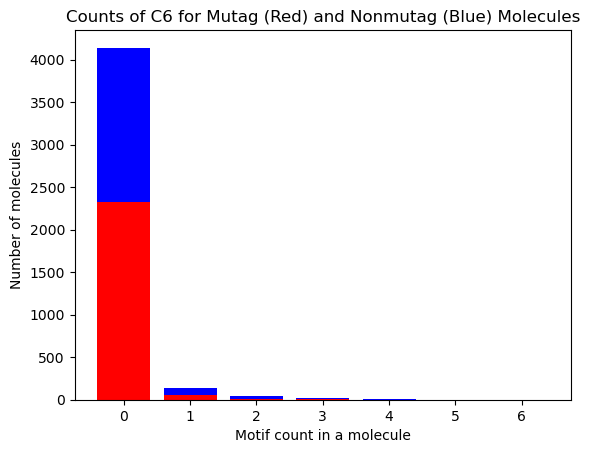

In [28]:
# C6
fig, ax = plt.subplots()

x = range(min_count, max_count+1)
y_mutag = mutag_hist[0]
y_nonmutag = nonmutag_hist[0]

ax.bar(x, y_mutag, color='r')
ax.bar(x, y_nonmutag, bottom=y_mutag, color='b')
ax.set_title('Counts of C6 for Mutag (Red) and Nonmutag (Blue) Molecules')
ax.set_xlabel('Motif count in a molecule')
ax.set_ylabel('Number of molecules')

# Dataset Statistics

In [29]:
# Class balance in dataset
mutag_count = 0
nonmutag_count = 0
for data in dataset:
    if data.mutagenicity == 'mutagen':
        mutag_count += 1
    elif data.mutagenicity == 'nonmutagen':
        nonmutag_count += 1

print(f'Mutagen count: {mutag_count}')
print(f'Nonmutagen count: {nonmutag_count}')

Mutagen count: 2401
Nonmutagen count: 1936


In [53]:
# Number of nodes vs edges for each sample in the graph
num_nodes = []
num_edges = []
for data in dataset:
    num_nodes.append(data.num_nodes)
    num_edges.append(int(data.num_edges / 2))

In [54]:
print(num_nodes)
print(num_edges)

[16, 72, 14, 36, 41, 11, 35, 8, 46, 50, 28, 16, 12, 42, 56, 17, 31, 14, 26, 13, 38, 39, 24, 22, 21, 33, 30, 48, 14, 24, 32, 26, 34, 20, 41, 10, 18, 62, 165, 11, 24, 29, 35, 18, 18, 27, 42, 22, 18, 30, 20, 17, 24, 27, 94, 25, 34, 44, 37, 26, 18, 45, 44, 35, 31, 22, 47, 26, 26, 23, 29, 30, 22, 35, 17, 38, 27, 48, 29, 31, 31, 12, 28, 34, 25, 19, 11, 64, 36, 39, 15, 40, 23, 53, 30, 32, 14, 8, 26, 26, 14, 47, 14, 39, 73, 68, 28, 26, 23, 44, 16, 27, 28, 13, 28, 43, 23, 18, 35, 25, 20, 42, 37, 24, 44, 32, 22, 57, 19, 18, 31, 69, 24, 106, 23, 27, 15, 22, 55, 16, 30, 60, 58, 38, 57, 60, 29, 17, 57, 26, 35, 31, 26, 15, 25, 17, 32, 5, 85, 27, 30, 68, 26, 19, 38, 24, 39, 75, 24, 21, 38, 20, 17, 36, 44, 45, 8, 73, 23, 25, 21, 36, 67, 31, 17, 42, 18, 17, 15, 14, 28, 18, 4, 28, 9, 20, 18, 12, 20, 23, 35, 37, 78, 44, 29, 12, 56, 20, 28, 29, 13, 26, 28, 20, 42, 15, 35, 24, 24, 78, 108, 15, 35, 22, 26, 35, 19, 18, 20, 19, 23, 46, 28, 34, 34, 58, 25, 31, 29, 15, 16, 33, 69, 13, 34, 15, 116, 20, 18, 35, 2

Text(0, 0.5, 'num edges')

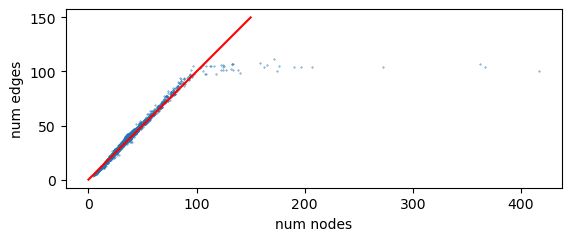

In [58]:
fig, ax = plt.subplots()
ax.scatter(num_nodes, num_edges, s=0.11)

x_one_to_one = np.linspace(0, 150, num=800)
y_one_to_one = np.linspace(0, 150, num=800)
ax.plot(x_one_to_one, y_one_to_one, color='r')

ax.set_aspect('equal')
ax.set_xlabel('num nodes')
ax.set_ylabel('num edges')

### Molecule Visualization

In [30]:
# from rdkit import Chem
# from rdkit.Chem import Draw

In [31]:
# def edge_label_to_rdkit_bond_type(edge_label):
#     if edge_label == '1':
#         return Chem.BondType.SINGLE
#     elif edge_label == '2':
#         return Chem.BondType.DOUBLE
#     elif edge_label == '3':
#         return Chem.BondType.TRIPLE
#     else:
#         raise Exception('Unknown edge label')

# #atom_mapping = get_node_feature_label_mapping()
# edge_mapping = get_edge_feature_label_mapping()
# bond_mapping = {}
# for val in edge_mapping.values():
#     bond_mapping[val] = edge_label_to_rdkit_bond_type(val)

# def visualize_molecule(data):
#     mol = Chem.RWMol()

#     for atom_symbol in data.atoms:
#         atom = Chem.Atom(atom_symbol)
#         mol.AddAtom(atom)
    
#     edge_index = data.edge_index
#     bonds = data.bonds
    
#     for i in range(len(bonds)):
#         start_atom = edge_index[0, i]
#         end_atom = edge_index[1, i]
#         bond_type = bond_mapping.get(bonds[i])
#         print(f'Start: {start_atom}, End: {end_atom}, Bond: {bond_type}')
#         mol.AddBond(int(start_atom), int(end_atom), bond_type)
    
#     mol = mol.GetMol()
#     img = Draw.MolToImage(mol, size=(300, 300))
#     return img

# img = visualize_molecule(data)
# img.show()